<a href="https://colab.research.google.com/github/FabioLiberti/Heterogeneous_Federated_Learning/blob/NOF_2023_P1/NOF2023_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from IPython.core.getipython import get_ipython

if "google.colab" in str(get_ipython()):
    !git clone https://github.com/phdcybersec/nof_2023.git
    %pip install poetry
    %pip install -r <(poetry export -C nof_2023/)
    !rm -r nof_2023/

Cloning into 'nof_2023'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 30 (delta 6), reused 7 (delta 2), pack-reused 14
Receiving objects: 100% (30/30), 31.58 MiB | 31.99 MiB/s, done.
Resolving deltas: 100% (7/7), done.
  Using cached virtualenv-20.25.0-py3-none-any.whl (3.8 MB)
  Attempting uninstall: virtualenv
    Found existing installation: virtualenv 20.21.0
    Uninstalling virtualenv-20.21.0:
      Successfully uninstalled virtualenv-20.21.0
In order to avoid a breaking change and make your automation forward-compatible, please install poetry-plugin-export explicitly. See https://python-poetry.org/docs/plugins/#using-plugins for details on how to install a plugin.
To disable this warning run 'poetry config warnings.export false'.
Ignoring ansicon: markers 'python_version >= "3.10" and python_version < "3.11" and platform_system == "Windows"' don't match your environment
Ignor

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from flwr.common import Metrics
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
import flwr
from tensorflow import keras
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
from numpy.typing import NDArray
from typing import cast
from typing import Callable

In [4]:
print("TensorFlow version:", tf.__version__)
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
enable_tf_gpu_growth()

TensorFlow version: 2.10.1
Num GPUs Available: 0


In [5]:
SEED = 1138
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [6]:
def load_mnist():
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # Make sure images have shape (28, 28, 1)
    print("x_train shape:", x_train.shape)
    print(x_train.shape[0], "train samples")
    print(x_test.shape[0], "test samples")

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)

    return (x_train, y_train), (x_test, y_test)

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


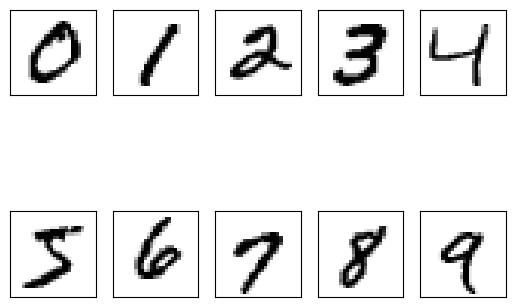

In [7]:
(x_train, y_train), (x_test, y_test) = load_mnist()

fig, ax = plt.subplots(2, 5)
for i, ax in enumerate(ax.flatten()):
    im_idx = np.argwhere(y_train[:, i] == 1)[0]
    plottable_image = np.reshape(x_train[im_idx], (28, 28))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.imshow(plottable_image, cmap="gray_r")

y_train shape: (60000, 10)
example: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


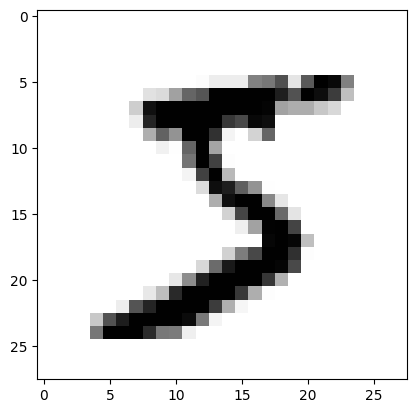

In [8]:
print("y_train shape:", y_train.shape)
print("example:", y_train[0])
# show the first image
plt.imshow(x_train[0].reshape(28, 28), cmap="gray_r")

In [9]:
def partition(num_shards: int, dataset: tuple[NDArray, NDArray]):
    """Download and partitions the MNIST dataset."""
    X, y = dataset
    partitions = []
    # We keep all partitions equal-sized in this example
    partition_size = math.floor(len(X) / num_shards)
    shuffle_idx = np.random.permutation(len(X))
    # X, y = X[shuffle_idx], y[shuffle_idx]
    for cid in range(num_shards):
        # Split dataset into non-overlapping NUM_CLIENT partitions
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        partitions.append((X[idx_from:idx_to], y[idx_from:idx_to]))
    return partitions

In [10]:
# Model / data parameters
BATCH_SIZE = 128
NUM_CLIENTS = 100

In [11]:
def mk_model() -> keras.Model:
    """Create a simple DNN model for MNIST classification."""

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )

    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    return model


mk_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [12]:
EPOCHS = 10

(x_train, y_train), (x_test, y_test) = load_mnist()
shards = partition(NUM_CLIENTS, (x_train, y_train))

# test the performance of the model on client 1
x_train, y_train = shards[0]

model = mk_model()
hist = model.fit(
    x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1
)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
Epoch 1/10
5/5 [==============================] - 1s 74ms/step - loss: 2.1530 - accuracy: 0.2648 - val_loss: 1.8504 - val_accuracy: 0.5833
Epoch 2/10
5/5 [==============================] - 0s 12ms/step - loss: 1.6502 - accuracy: 0.6278 - val_loss: 1.5177 - val_accuracy: 0.6833
Epoch 3/10
5/5 [==============================] - 0s 12ms/step - loss: 1.2817 - accuracy: 0.7333 - val_loss: 1.2286 - val_accuracy: 0.7833
Epoch 4/10
5/5 [==============================] - 0s 13ms/step - loss: 0.9884 - accuracy: 0.7796 - val_loss: 1.0196 - val_accuracy: 0.8500
Epoch 5/10
5/5 [==============================] - 0s 16ms/step - loss: 0.7811 - accuracy: 0.8222 - val_loss: 0.8545 - val_accuracy: 0.8333
Epoch 6/10
5/5 [==============================] - 0s 14ms/step - loss: 0.6570 - accuracy: 0.8500 - val_loss: 0.7415 - val_accuracy: 0.8500
Epoch 7/10
5/5 [==============================] - 0s 13ms/step - loss: 0.5370 - accuracy: 0.8815

In [13]:
score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.6072 - accuracy: 0.8175
Test loss: 0.6072008013725281
Test accuracy: 0.8174999952316284


In [14]:
def get_evaluate_fn(testset):
    """Return an evaluation function for server-side (i.e. centralized) evaluation."""
    x_test, y_test = testset

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: flwr.common.NDArrays,
        config: dict[str, flwr.common.Scalar],
    ):
        model = mk_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(x_test, y_test, verbose=cast(str, 0))
        return loss, {"accuracy": accuracy}

    return evaluate

In [15]:
class FlowerClient(flwr.client.NumPyClient):
    def __init__(self, x_train, y_train):  # , x_eval, y_eval) -> None:
        # Create model
        self.model = mk_model()
        self.x_train, self.y_train = x_train, y_train
        # self.x_eval, self.y_eval = x_eval, y_eval

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(
            self.x_train,
            self.y_train,
            epochs=1,
            batch_size=BATCH_SIZE,
            verbose=cast(str, 0),
            validation_split=0.1,
        )
        return self.model.get_weights(), len(self.x_train), {}

In [16]:
def mk_client_fn(
    partitions: list[tuple[NDArray, NDArray]]
) -> Callable[[str], FlowerClient]:
    """Return a function which creates a new FlowerClient for a given partition."""

    def client_fn(cid: str) -> FlowerClient:
        """Create a new FlowerClient for partition i."""
        x_train, y_train = partitions[int(cid)]
        return FlowerClient(x_train, y_train)

    return client_fn

In [17]:
# Enable GPU growth in your main process
enable_tf_gpu_growth()

# Create dataset partitions (needed if your dataset is not pre-partitioned)
trainset, testset = load_mnist()
partitions = partition(NUM_CLIENTS, trainset)


# Create FedAvg strategy
strategy = flwr.server.strategy.FedAvg(
    fraction_fit=0.1,  # Sample 10% of available clients for training
    fraction_evaluate=0,  # Disable federated evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    # min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS * 0.75
    ),  # Wait until at least 75 clients are available
    # evaluate_metrics_aggregation_fn=avg_metrics,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(testset),  # global evaluation function
)

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# Start simulation
history = flwr.simulation.start_simulation(
    client_fn=mk_client_fn(partitions),
    num_clients=NUM_CLIENTS,
    config=flwr.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },
    ray_init_args={"num_gpus": len(tf.config.list_physical_devices("GPU"))},
)

INFO flwr 2024-02-19 15:05:20,262 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


2024-02-19 15:05:25,896	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2024-02-19 15:05:28,432 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3921947443.0, 'memory': 7843894887.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3921947443.0, 'memory': 7843894887.0}
INFO flwr 2024-02-19 15:05:28,436 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-02-19 15:05:28,505 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO:flwr:Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO flwr 2024-02-19 15:05:28,521 | server.py:89 | Initializing global p

history.metrics_centralized = {'accuracy': [(0, 0.0746999979019165), (1, 0.4925999939441681), (2, 0.7138000130653381), (3, 0.7702000141143799), (4, 0.8159999847412109), (5, 0.8371000289916992), (6, 0.8551999926567078), (7, 0.8607000112533569), (8, 0.8723999857902527), (9, 0.8784999847412109), (10, 0.8815000057220459)]}


Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

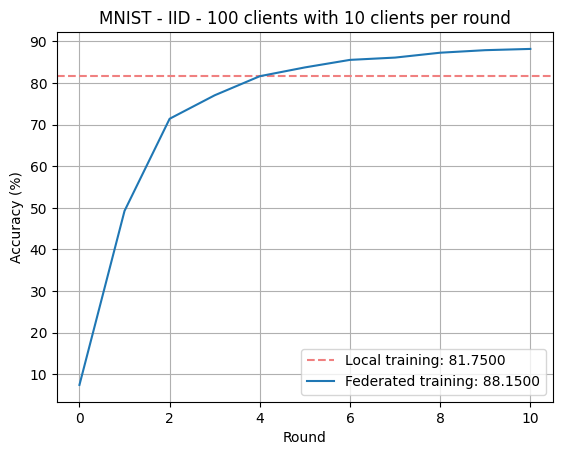

In [18]:
print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]

local = score[1] * 100
plt.axhline(
    y=local, label=f"Local training: {local:.4f}", linestyle="--", color="lightcoral"
)
plt.plot(round, acc, label=f"Federated training: {max(acc):.4f}")
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.legend()
plt.title("MNIST - IID - 100 clients with 10 clients per round")